# デュアル構造を持つネットワークの検索用ノートブック(2019/11/26作成)

- リファクタリングを兼ねてもう一度綺麗に実装してみる

## 初期設定とライブラリのimport

In [1]:
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt 
from tqdm import tqdm
import os

In [2]:
BASE_PATH = './dataset/crop_img/img/DRESSES/Dress/'
category = 'Dress'

## エラー対応
- ~~**RTX系のGPU**で回すとUnknownErrorを吐くため以下コードにより回避~~
- なぜかこちらのコードがエラーを吐くようになった(GPUマシンのアップデート後)
- GPU番号を指定していないことが原因らしい

In [3]:
# import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# tf.keras.backend.set_session(tf.Session(config=config))

- GPUを指定する

In [4]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
        visible_device_list="0", # specify GPU number
        allow_growth=True
    )
)
set_session(tf.Session(config=config))

/opt/anaconda3/envs/zukapy35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## モデルの読み込み

In [5]:
from keras.models import load_model

In [6]:
vec_length = 300
model_epoch = 99
ALPHA = 0.1
BETA = 0.05 #improved triplet lossの場合

In [7]:
# model_dir = "./model/T_Shirt/improved_tripletloss/a{}b{}".format(ALPHA,BETA)
# model_dir = "./model/{}/Dual_normal/a{}".format(category,ALPHA)
model_dir = "./model/{}/Dual_improved/a{}b{}".format(category,ALPHA,BETA)
os.listdir(model_dir)

['500', '.ipynb_checkpoints', '300']

In [8]:
con_embNet = load_model(model_dir+'/{}/con_e{}.h5'.format(vec_length,model_epoch), compile=False)
shop_embNet = load_model(model_dir+'/{}/shop_e{}.h5'.format(vec_length,model_epoch), compile=False)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
# con_embNet = load_model('./model/T_Shirt/tripletloss/a0.1/512/con_e99.h5', compile=False)
# shop_embNet = load_model('./model/T_Shirt/tripletloss/a0.1/512/shop_e99.h5', compile=False)

## Testデータの読み込み
- 学習前にtrain/test分割してpickle保存したファイルからtestに用いる商品idをロードする
- 一つの商品idに対して一つの[Street画像,Shop画像]ペアとする。詳しくは`./datagen.py`参照

In [10]:
f = open("./pickle/{}/test_ids.pickle".format(category),"rb")
test_ids = pickle.load(f) #test用の商品id

- 自作モジュールのインポート

In [11]:
from modules import datagen

In [12]:
test_pairs = datagen.get_test_pairs(test_ids,BASE_PATH,seed_num=0)

100%|██████████| 879/879 [00:00<00:00, 6023.87it/s]


- 中身は`[商品id,[Street画像のパス,Shop画像のパス]]`

In [13]:
test_pairs[0]

[14966,
 ['./dataset/crop_img/img/DRESSES/Dress/id_00014966/comsumer_01.jpg',
  './dataset/crop_img/img/DRESSES/Dress/id_00014966/shop_01.jpg']]

- 作成したtest_pairsをpickleで保存する

In [14]:
f = open('./pickle/{}/test_pairs.pickle'.format(category), 'wb')
pickle.dump(test_pairs, f)

## 検索対象の画像群(gallery)の作成

- galleryリストに対して、test_pairsから[商品id, Shop画像パス]のリスト作成してappendする

In [15]:
gallery = []
for tp in test_pairs:
    gallery.append([tp[0],tp[1][1]])

In [16]:
print(gallery[0])
print('gallery length = {}'.format(len(gallery)))

[14966, './dataset/crop_img/img/DRESSES/Dress/id_00014966/shop_01.jpg']
gallery length = 879


## galleryを特徴空間ベクトルに埋め込む

- 埋め込み次元はvec_lengthとして定義済み
- 最初に次元数分のnumpy配列を用意しておき、書き換える。
- ans_idsは正解となる商品idのリスト(test_pairsをforで回してtp[0]のリストを作るのと同義)

In [17]:
emb_vecs = np.zeros((len(gallery),vec_length))
ans_ids = np.zeros(len(gallery))
print(emb_vecs.shape)
print(ans_ids.shape)

(879, 300)
(879,)


- shop_embNet.predict()で推論を行う。デュアル構造のため、入力として同じimgを二つ与える
- 入力時の形を合わせるためexpand_dimsの処理が必要(試行錯誤の結果なので詳細は忘れた)

In [18]:
for i,g in enumerate(tqdm(gallery)):
    img =np.array(Image.open(g[1]).resize((128,128)).convert('RGB'))/255.
    ans_ids[i] = g[0]
    emb_vecs[i] = shop_embNet.predict([np.expand_dims(img,axis=0),np.expand_dims(img,axis=0)])[0] # need [0] because of expanding dimension -> [[]]

  0%|          | 0/879 [00:00<?, ?it/s]


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node model_1_1/conv2d_1/convolution}}]]
	 [[{{node concatenate_2/concat}}]]

- **重要!!** 後に結果を解釈するために埋め込んだベクトルをpickleに保存

In [19]:
f = open(model_dir+'/{}/gallery{}.txt'.format(vec_length,model_epoch),'wb')
pickle.dump(emb_vecs,f)

In [20]:
# f = open('./model/T_Shirt/tripletloss/a{}/{}/gallery{}.txt'.format(ALPHA,vec_length,model_epoch),'wb')
# pickle.dump(emb_vecs,f)

- ユークリッド距離計算用関数

In [21]:
def euclid_dist(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

- Queryの用意

In [22]:
query_ids = np.zeros(len(test_pairs))
print(query_ids.shape)

(894,)


In [23]:
for i,tp in enumerate(test_pairs):
    query_ids[i] = tp[0]
query_ids[:5]

array([20455., 22017., 10211., 23875.,  6604.])

## 距離計算とランキングの算出
- topN_id_listはそれぞれのqueryに対し上位N個までの商品idのランキングがリストとして算出される。
- [[商品Aのランキング],[商品Bのランキング],...[商品Xのランキング],...]のような形

In [24]:
N = 50

- Street画像(Query)の**埋め込みと距離計算**
- argsort()は昇順に並べたときのindexの配列を返す
- similaritiesとans_idsの同じインデックスは同じ商品idを指している
- つまり、対応するans_idsをidxsリストを与えることで切り出す

In [25]:
topN_id_list = []
query_emb_vecs = np.zeros((len(gallery),vec_length))
for i,tp in enumerate(tqdm(test_pairs)):
    img = np.array(Image.open(tp[1][0]).resize((128,128)).convert('RGB'))/255.
    query_emb = con_embNet.predict([np.expand_dims(img.astype(np.float32),axis=0),np.expand_dims(img.astype(np.float32),axis=0)])[0]
    query_emb_vecs[i] = query_emb
    # calculation
    similarities = np.zeros(len(gallery))
    for i,emb_vec in enumerate(emb_vecs):
        similarities[i] = euclid_dist(query_emb,emb_vec)
    # argsort
    idxs = similarities.argsort()
    topN_id_list.append(ans_ids[idxs[:N]])  

100%|██████████| 894/894 [00:11<00:00, 75.71it/s]


In [26]:
topN_id_list[0]

array([ 2449., 22017.,  5424., 23642., 13795., 27649., 28404., 30755.,
        5012.,  1505., 27654.,  4819., 24651.,  8584.,  8893., 28047.,
        6178., 33589.,   355.,  9116., 33122., 28746.,   238., 10737.,
       16845., 12749., 33814., 33732.,  8191.,  8174., 18149., 13726.,
       21464., 19908., 12472.,  1066., 31435., 16962., 29020., 22000.,
        2839., 31742., 30218.,  3502.,  2476., 15638.,  2008., 28441.,
        3197.,  4904.])

- 検索結果画像を表示するためにtopN_id_listを保存

In [27]:
f = open(model_dir+'/{}/topN_id_list{}.txt'.format(vec_length,model_epoch),'wb')
pickle.dump(topN_id_list,f)

In [28]:
# f = open('./model/T_Shirt/tripletloss/a{}/{}/topN_id_list{}.txt'.format(ALPHA,vec_length,model_epoch),'wb')
# pickle.dump(topN_id_list,f)

In [29]:
len(emb_vecs)

894

- **重要!!** のちに結果を解釈(**ヒストグラム描画**など)するためquery_embをpickle保存

In [30]:
f = open(model_dir+'/{}/query{}.txt'.format(vec_length,model_epoch),'wb')
pickle.dump(query_emb_vecs,f)

In [31]:
# f = open('./model/T_Shirt/tripletloss/a{}/{}/query{}.txt'.format(ALPHA,vec_length,model_epoch),'wb')
# pickle.dump(query_emb_vecs,f)

## Top-Kの計算とグラフの描画

- ans_idsとtopN_id_listをzipで同時に回す
- あるans_idを見たとき、対応するインデックスのtopN_idの中に同じidが入っていればcntを+1

In [32]:
def calc_topk_vals(k_values,ans_ids,topN_id_list):
    topk_vals = []
    for k in k_values:
        cnt = 0
        for i,(ans_id,topN_id) in enumerate(zip(ans_ids,topN_id_list)):
            if ans_id in topN_id[:k]:
                cnt+=1
        topk_vals.append(cnt/len(ans_ids))
    return topk_vals

In [33]:
x = list(range(1,51))
topk_vals = calc_topk_vals(x,ans_ids,topN_id_list)

In [38]:
f = open(model_dir+'/{}/topK_vals.txt'.format(vec_length), 'wb')
pickle.dump(topk_vals, f)

In [35]:
# f = open('./model/T_Shirt/topK/TripletLoss_{}.txt'.format(vec_length), 'wb')
# pickle.dump(topk_vals, f)

In [36]:
topk_vals

[0.030201342281879196,
 0.042505592841163314,
 0.049217002237136466,
 0.05480984340044743,
 0.06040268456375839,
 0.07606263982102908,
 0.08053691275167785,
 0.087248322147651,
 0.09172259507829977,
 0.09507829977628636,
 0.10067114093959731,
 0.10850111856823266,
 0.11297539149888143,
 0.116331096196868,
 0.12080536912751678,
 0.12639821029082773,
 0.1319910514541387,
 0.14093959731543623,
 0.14093959731543623,
 0.1476510067114094,
 0.15324384787472037,
 0.1610738255033557,
 0.16554809843400448,
 0.16890380313199105,
 0.17114093959731544,
 0.174496644295302,
 0.1767337807606264,
 0.18232662192393737,
 0.18680089485458612,
 0.1890380313199105,
 0.1912751677852349,
 0.1935123042505593,
 0.19686800894854586,
 0.20246085011185683,
 0.203579418344519,
 0.20693512304250558,
 0.21029082774049218,
 0.21364653243847875,
 0.21700223713646533,
 0.2214765100671141,
 0.22483221476510068,
 0.22706935123042504,
 0.22818791946308725,
 0.23042505592841164,
 0.2371364653243848,
 0.24161073825503357,
 0

- グラフの描画

/home/pip/koki_ishizuka/.conda/envs/py35-zukapy/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


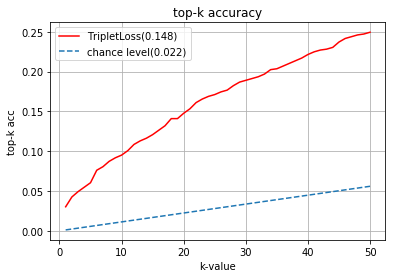

In [37]:
x = list(range(1,51))
chancelv=np.array(x)/len(test_pairs)

topk_vals = calc_topk_vals(x,ans_ids,topN_id_list)
plt.plot(x,topk_vals,c='r',label='TripletLoss({})'.format(round(topk_vals[19],3)))
# plt.plot(x,topk_vals,c='r',marker='o',label='improvedTripletLoss({})'.format(round(topk_vals[4],3)))
plt.plot(x,chancelv,linestyle='dashed',label='chance level({})'.format(round(chancelv[19],3)))

# graph settings
plt.legend(loc='best')#,bbox_to_anchor=(1, 0.2))
plt.grid('True')
plt.title("top-k accuracy")
plt.xlabel("k-value")
plt.ylabel("top-k acc")
plt.show()

# 結果と考察

- vec_lengthは結果に対してかなり影響がある

Top20 accuracy

| Dimension | Single | Dual(Triplet Loss) | Dual(improved Triplet Loss) |
|:-:|:-:|:-:|:-:|
|100|  0.141  | - | -|
|200|-  |0.175  | - |
|300|-  | 0.126 | 0.201 |
|512|0.2  |0.156  |0.108  |

alpha=0.5にしたら0.157に変化した
原因はhistgram要確認
